<h1>Node Degree Bias</h1>

<p>The purpose of this notebook is to demonstrate the influence of node degree on the performance of graph machine learning.</p>

In [86]:
from grape.datasets.kghub import SLDB
from grape.datasets.string import HomoSapiens

from grape.embedders import FirstOrderLINEEnsmallen, SecondOrderLINEEnsmallen
from grape.embedders import DeepWalkGloVeEnsmallen, DeepWalkCBOWEnsmallen, DeepWalkSkipGramEnsmallen
from grape.embedders import WalkletsGloVeEnsmallen, WalkletsCBOWEnsmallen, WalkletsSkipGramEnsmallen
from grape.embedders import HOPEEnsmallen

from grape.edge_prediction import edge_prediction_evaluation
from grape.edge_prediction import PerceptronEdgePrediction
import pandas as pd
import os
from tqdm.auto import tqdm
from IPython.display import HTML
import warnings

warnings.filterwarnings('ignore')

<h3>Load and process the graphs</h3>

In [87]:
sli_graph = SLDB()
string_graph = HomoSapiens()
graph_root = os.environ.get("GRAPH_CACHE_DIR", "./graphs")

path = f"{graph_root}/string/HomoSapiens/links.v11.5/9606.protein.info.v11.5.txt"
data = pd.read_csv(path, sep="\t")
remapping_string = dict(zip(data[data.columns[0]], data[data.columns[1]]))
string_graph = string_graph\
    .remove_node_types()\
    .filter_from_names(min_edge_weight=700)\
    .remove_edge_weights()\
    .remap_from_node_names_map(remapping_string)\
    .set_all_node_types("Gene")\
    .set_all_edge_types("PPI")\
    .remove_disconnected_nodes()
path = f"{graph_root}/kghub/SLDB/20220522/sldb/merged-kg_nodes.tsv"
data = pd.read_csv(path, sep="\t")
remapping_sli = dict(zip(data[data.columns[0]], data[data.columns[2]]))

<h3>Restrict the SLI graph to the largest connected component</h3>

In [88]:
sli_graph = sli_graph.remap_from_node_names_map(remapping_sli).set_all_node_types("Gene").set_all_edge_types("SLI")
composite_graph = (sli_graph | string_graph).remove_components(top_k_components=1)

subgraph = composite_graph.filter_from_names(
    edge_type_names_to_keep=["SLI"]
)

<h3>Constants</h3>
<p>The results presented here are typical for results obtained with a wide range of parameter settings.
The following settings can be changed here for the entire workbook.</p>

In [89]:
# Set smoke test to True for testing:
SMOKE_TEST = True
NUMBER_OF_HOLDOUTS = 10
VALIDATION_UNBALANCE_RATES = (1.0, )
TRAIN_SIZES = (0.75,)

<h2>Analyzing Perceptron Prediction of SLIs based only on node degree data</h2>
<p>The following code tests the performance of predicting SLI edges based only on edge data (no graph machine learning is used; instead the following analysis uses various approaches to creating features based on the the node degrees of each edge (u,v), with the degree of node u being d(u)</p>
<ol>
    <li>Degree: The perceptron is given a two dimensional vector with [d(u), d(v)]</li>
    <li>AdamicAdar index (See <a href="https://en.wikipedia.org/wiki/Adamic%E2%80%93Adar_index">Wikipedia</a>).</li>
    <li>JaccardCoefficient: the perceptron is given a single scalar equivalent to the count of shared neighbors divided by the count of the union of all neighbors.</li>
     <li>ResourceAllocationIndex: See <a href="https://arxiv.org/pdf/0901.0553.pdf">Zhou et al, 2009</a>.</li> 
     <li>PreferentialAttachment: the perceptron is given a single scalar equal to d(u)*d(v)</li>

In [5]:
results = []

fresults = []
train_size = 0.75
for validation_use_scale_free in tqdm(
    (True, False),
    desc="Validation use scale free",
    leave=False
):
    results.append(edge_prediction_evaluation(
        smoke_test=SMOKE_TEST,
        holdouts_kwargs=dict(
            train_size=train_size,
            edge_types=["SLI"],
        ),
        evaluation_schema="Connected Monte Carlo",
        graphs=composite_graph,
        models=[
            PerceptronEdgePrediction(
                edge_features=edge_feature,
                number_of_epochs=1000,
                number_of_edges_per_mini_batch=16,
                learning_rate=0.001,
                use_scale_free_distribution=use_scale_free_distribution
            )
            for edge_feature in ("Degree","AdamicAdar","JaccardCoefficient","ResourceAllocationIndex","PreferentialAttachment") 
            for use_scale_free_distribution in (True, False)
        ],
        #number_of_slurm_nodes=NUMBER_OF_HOLDOUTS,
        enable_cache=True,
        number_of_holdouts=NUMBER_OF_HOLDOUTS,
        use_scale_free_distribution=validation_use_scale_free,
        validation_unbalance_rates=VALIDATION_UNBALANCE_RATES,
        subgraph_of_interest=subgraph,
        use_subgraph_as_support=False
    ))
results = pd.concat(results)
results.to_csv("degree_only_perceptron.tsv",sep="\t")

Validation use scale free:   0%|          | 0/2 [00:00<?, ?it/s]

Evaluating on (SLDB | HomoSapiens):   0%|                | 0/10 [00:00<?, ?it/s]

  0%|                                                    | 0/10 [00:00<?, ?it/s]

  0%|                                                    | 0/10 [00:00<?, ?it/s]

  0%|                                                    | 0/10 [00:00<?, ?it/s]

  0%|                                                    | 0/10 [00:00<?, ?it/s]

  0%|                                                    | 0/10 [00:00<?, ?it/s]

  0%|                                                    | 0/10 [00:00<?, ?it/s]

  0%|                                                    | 0/10 [00:00<?, ?it/s]

  0%|                                                    | 0/10 [00:00<?, ?it/s]

  0%|                                                    | 0/10 [00:00<?, ?it/s]

  0%|                                                    | 0/10 [00:00<?, ?it/s]

Evaluating on (SLDB | HomoSapiens):   0%|                | 0/10 [00:00<?, ?it/s]

  0%|                                                    | 0/10 [00:00<?, ?it/s]

  0%|                                                    | 0/10 [00:00<?, ?it/s]

  0%|                                                    | 0/10 [00:00<?, ?it/s]

  0%|                                                    | 0/10 [00:00<?, ?it/s]

  0%|                                                    | 0/10 [00:00<?, ?it/s]

  0%|                                                    | 0/10 [00:00<?, ?it/s]

  0%|                                                    | 0/10 [00:00<?, ?it/s]

  0%|                                                    | 0/10 [00:00<?, ?it/s]

  0%|                                                    | 0/10 [00:00<?, ?it/s]

  0%|                                                    | 0/10 [00:00<?, ?it/s]

<h2>Preferential attachment</h2>
<p>The mechanism of
preferential attachment can be used to generate evolving
scale-free networks (i.e., networks with power-law degree
distributions), where the probability that a new link is
connected to the node x is proportional to k(x). A similariytmatrix can be defined as s<sub>uv</sub> = d(u) × d(v). </p>
<p>It was described in 2011 that node degree alone can be used for many predictions in bioinformatics (<a href="https://pubmed.ncbi.nlm.nih.gov/21364756/">Gillis J, Pavlidis P. The impact of multifunctional genes on "guilt by association" analysis. PLoS One. 2011 Feb 18;6(2):e17258.</a>). In the following cell, we show that sampling the SLI graph in three different ways leads to substantially different distributions, which in principle yield features that can be leveraged for classification. However, unless the biological signal one is looking for is node degree, it is likely that the classifier is not doing what the user expected.</p> 

Text(0, 0.5, 'Count (log scale)')

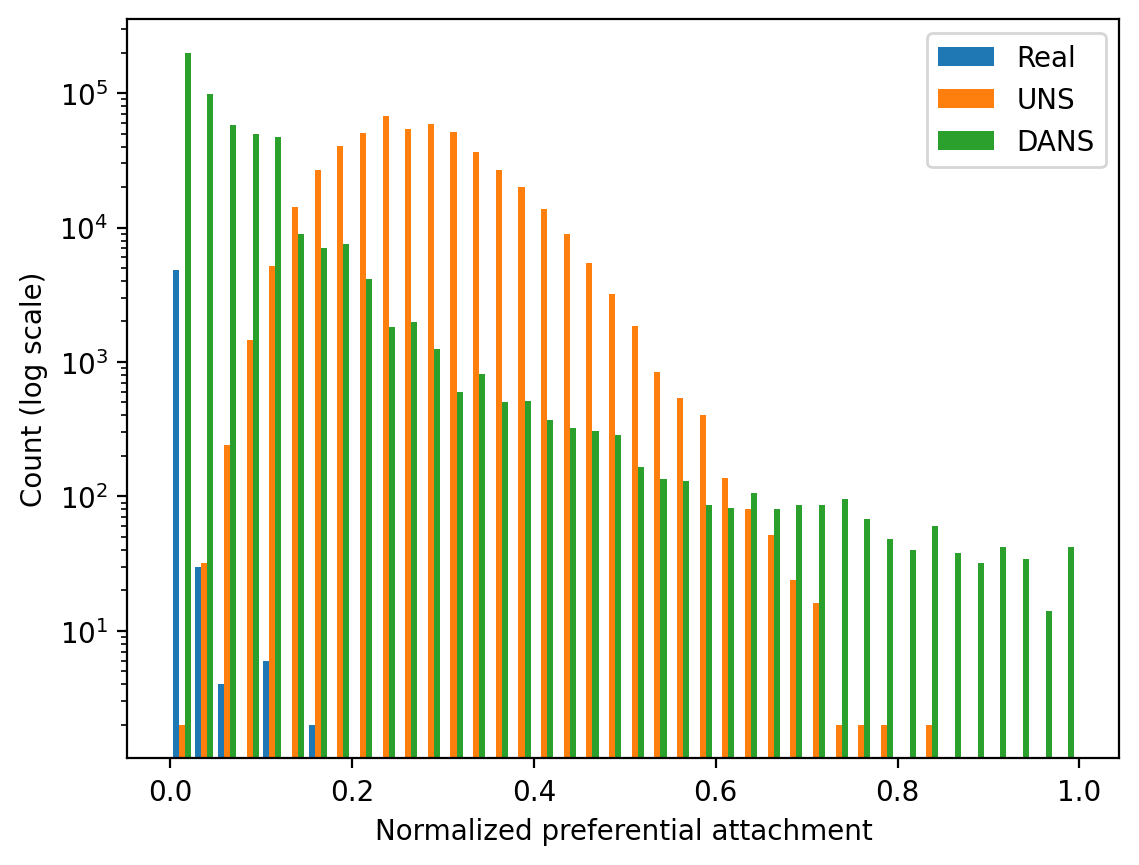

In [6]:
import matplotlib.pyplot as plt

negative = subgraph.sample_negative_graph(
    number_of_negative_samples=subgraph.get_number_of_edges() * 100,
    use_scale_free_distribution=False,
)

negative_scale_free = subgraph.sample_negative_graph(
    number_of_negative_samples=subgraph.get_number_of_edges() * 100,
    use_scale_free_distribution=True,
)


fig, axes = plt.subplots(dpi=200)

plt.hist([
    subgraph.get_preferential_attachment_scores(),
    negative.get_preferential_attachment_scores(),
    negative_scale_free.get_preferential_attachment_scores()
],
    log=True, bins=40, label=["Real", "UNS", "DANS"])
plt.legend()
plt.xlabel("Normalized preferential attachment")
plt.ylabel("Count (log scale)")

<h2>Plotting results of node-degree based classification</h2>
<p>???</p>

In [103]:
import numpy as np
import pandas as pd
from glob import glob
import json


df = results.copy()

#df = df[df.evaluation_mode == "test"]

df["train_size"] = [
    float(json.loads(holdouts_kwargs)["train_size"])
    for holdouts_kwargs in df.holdouts_kwargs
]

df["features_names"] = [
    json.loads(edge_feature.replace("'", "\""))[0] if pd.notna(edge_feature) else feature_name
    for feature_name, edge_feature in zip(
        df.features_names,
        df[('model_parameters', 'edge_features')]
    )
]

df["use_scale_free_distribution"] = [
    "DANS"
    if use_scale_free_distribution
    else "UNS"
    for use_scale_free_distribution in df.use_scale_free_distribution
]

if False:
    df = df[
        [
            pd.isna(a) or a == b
            for a, b in zip(
                #df[('features_parameters', 'use_scale_free_distribution')],
                df[('model_parameters', 'use_scale_free_distribution')],
            )
        ]
    ]

df = df[df["validation_unbalance_rate"] == 1]
df = df[df["train_size"] == 0.75]

# Features that we do not want to show
allow_list = [
    "degree",
    #"resource"
]

df["features_names"] = [
    "{feature} {training} (ANN)".format(
        training=("DANS"
        if b
        else "UNS"),
        feature=feature
    )
    for b, feature in zip(
        #df[('features_parameters', 'use_scale_free_distribution')],
        df[('model_parameters', 'use_scale_free_distribution')],
        df["features_names"]
    )
]

mask = np.array([
    any(target in feature.lower() for target in allow_list)
    for feature in df["features_names"]
])

df = df[mask]

df["features_names"] = [
    feature.replace("ResourceAllocationIndex", "RAI").replace("Degree", "")
    for feature in df["features_names"]
]

df["validation"] = df["use_scale_free_distribution"]

In [141]:
df = results.copy()
df["validation"] = df["use_scale_free_distribution"].map({True: 'DANS', False: 'UNS'})
df["edge_features"] = df[("model_parameters", "edge_features")]
perceptron_dans_df = df[df[('model_parameters', 'use_scale_free_distribution')]==True]
perceptron_uns_df = df[df[('model_parameters', 'use_scale_free_distribution')]==False]
perceptron_dans_df['validation'] = perceptron_dans_df['validation'].str.replace('DANS','DANS (*)')
perceptron_dans_df['validation'] = perceptron_dans_df['validation'].str.replace('UNS','UNS (*)')
#perceptron_uns_df['validation'] = perceptron_uns_df['validation'].str.replace('DANS','DANS (ANN:DANS)')
#perceptron_uns_df['validation'] = perceptron_uns_df['validation'].str.replace('UNS','UNS (ANN:DANS)')

In [142]:
perceptron_df = pd.concat([perceptron_dans_df, perceptron_uns_df])


<h2>Plotting</h2>
<p>The plotline library allows us to use most ggplot commands.</p>

In [114]:
from plotnine import *

In [151]:
perceptron_df["edge_features"]

0                     ['Degree']
1                     ['Degree']
0                 ['AdamicAdar']
1                 ['AdamicAdar']
0         ['JaccardCoefficient']
                ...             
1         ['JaccardCoefficient']
0    ['ResourceAllocationIndex']
1    ['ResourceAllocationIndex']
0     ['PreferentialAttachment']
1     ['PreferentialAttachment']
Name: edge_features, Length: 400, dtype: object

In [143]:
perceptron_df["edge_features"].unique()

array(["['Degree']", "['AdamicAdar']", "['JaccardCoefficient']",
       "['ResourceAllocationIndex']", "['PreferentialAttachment']"],
      dtype=object)

In [161]:
def get_ggplot(df, edge_feature):
    df_filtered = df[perceptron_df["edge_features"]==edge_feature]
    p = ggplot(data=df_filtered, mapping=aes(y = "matthews_correlation_coefficient", 
           x = "validation",  fill="evaluation_mode"))  + geom_boxplot()  + \
    theme_bw() +  \
    labs(y= "MCC") + \
    theme(axis_text = element_text(size=18),
         axis_title_x= element_blank(),
          axis_title_y= element_text(size=24),
         legend_title = element_blank(),
         legend_text = element_text(size=24, hjust=1),
         legend_position = (0.35, 0.9))
    return p

<h3>Feature Type: Degree</h3>

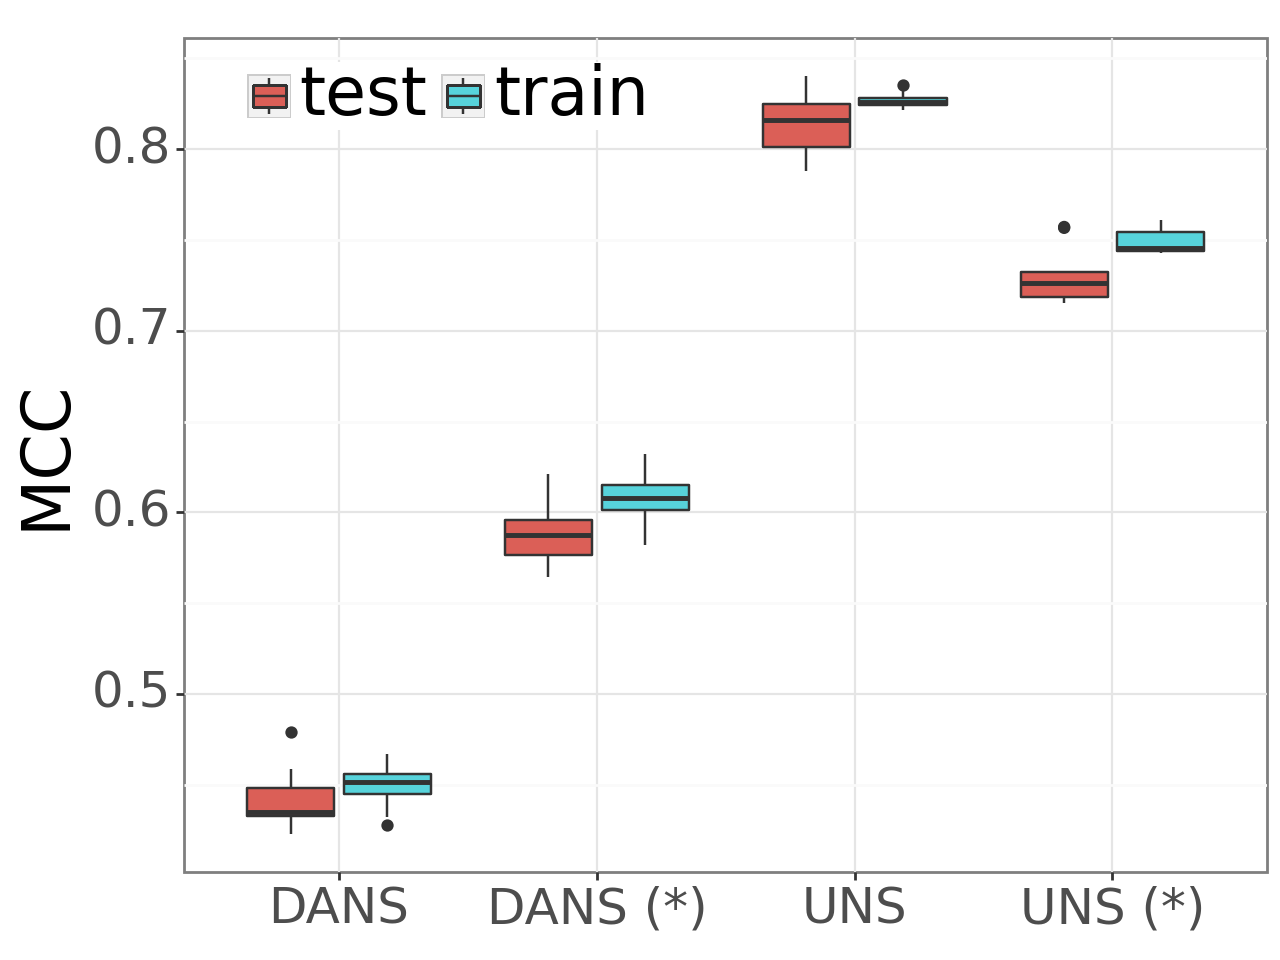

<Figure Size: (640 x 480)>

In [163]:
p = get_ggplot(perceptron_df, "['Degree']")
#ggsave(p, "degree_only_degree.pdf")
p

<p>Legend: Matthews correlation coefficient (MCC) analysis for classification of SLDB/STRING edges. The relative performance of DANS and UNS are compaired in test and training. The asterisk (*) denotes that DANS was also used in choosing negative samples for the Perceptron; if no asterisk is shown, then UNS was used for choosing negative samples for the Perceptron.</p>

<h3>Feature Type: AdamicAdar</h3>

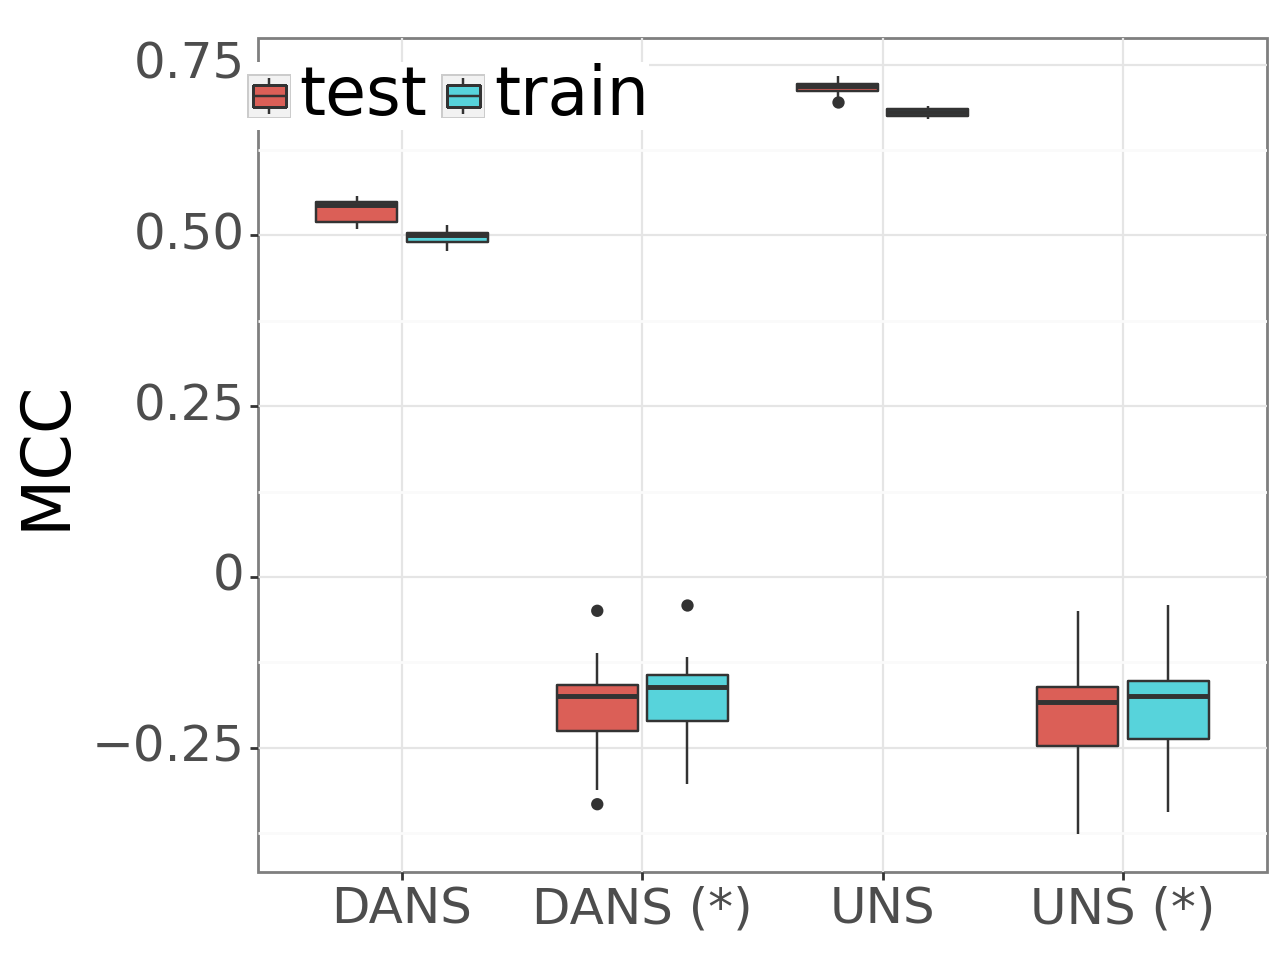

<Figure Size: (640 x 480)>

In [164]:
p = get_ggplot(perceptron_df, "['AdamicAdar']")
#ggsave(p, "degree_only_degree.pdf")
p

<h3>Feature Type: JaccardCoefficient</h3>

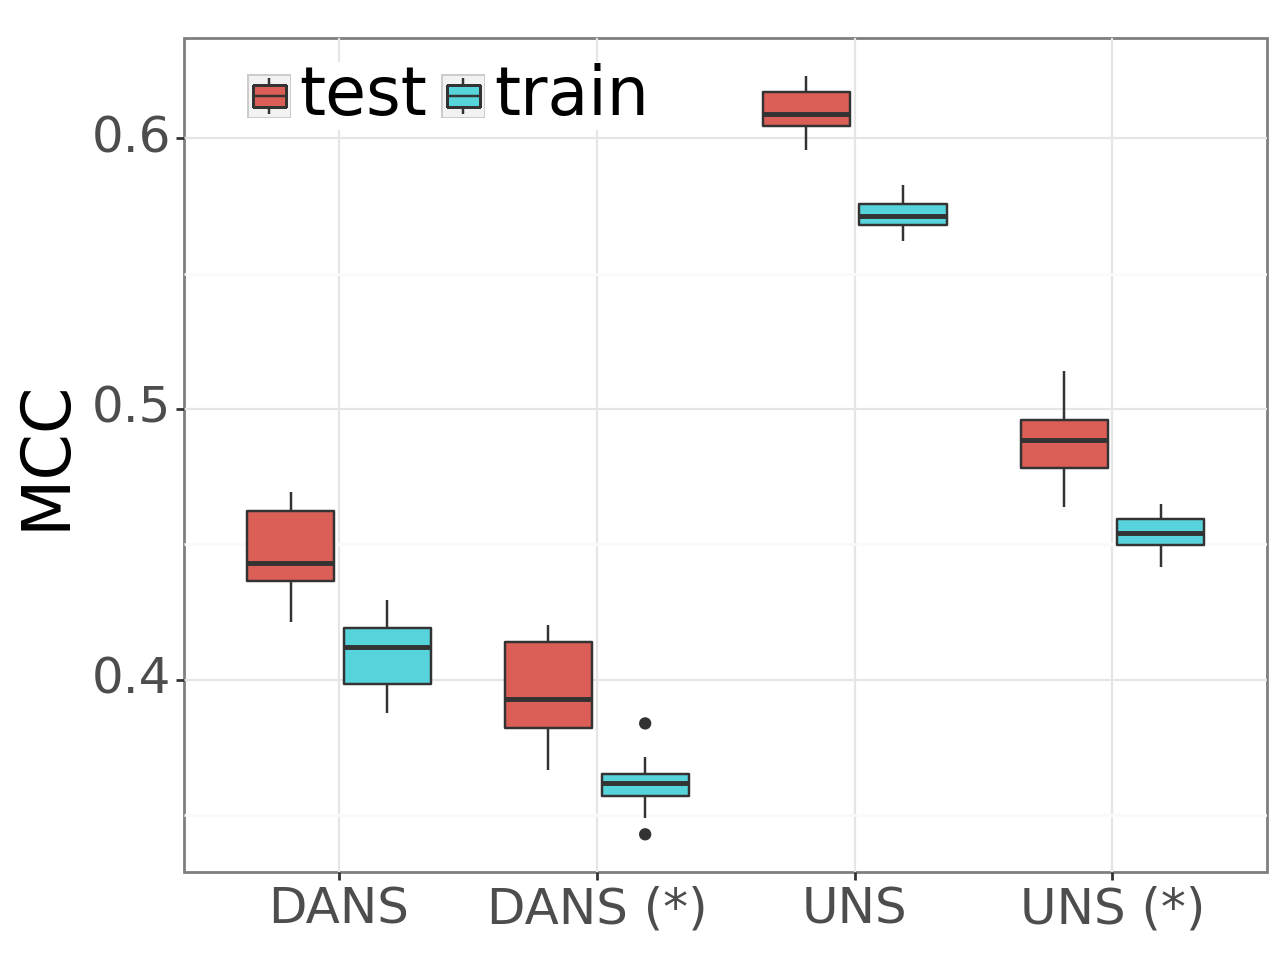

<Figure Size: (640 x 480)>

In [165]:
p = get_ggplot(perceptron_df, "['JaccardCoefficient']")
#ggsave(p, "degree_only_degree.pdf")
p 

<h3>Feature Type: ResourceAllocationIndex</h3>

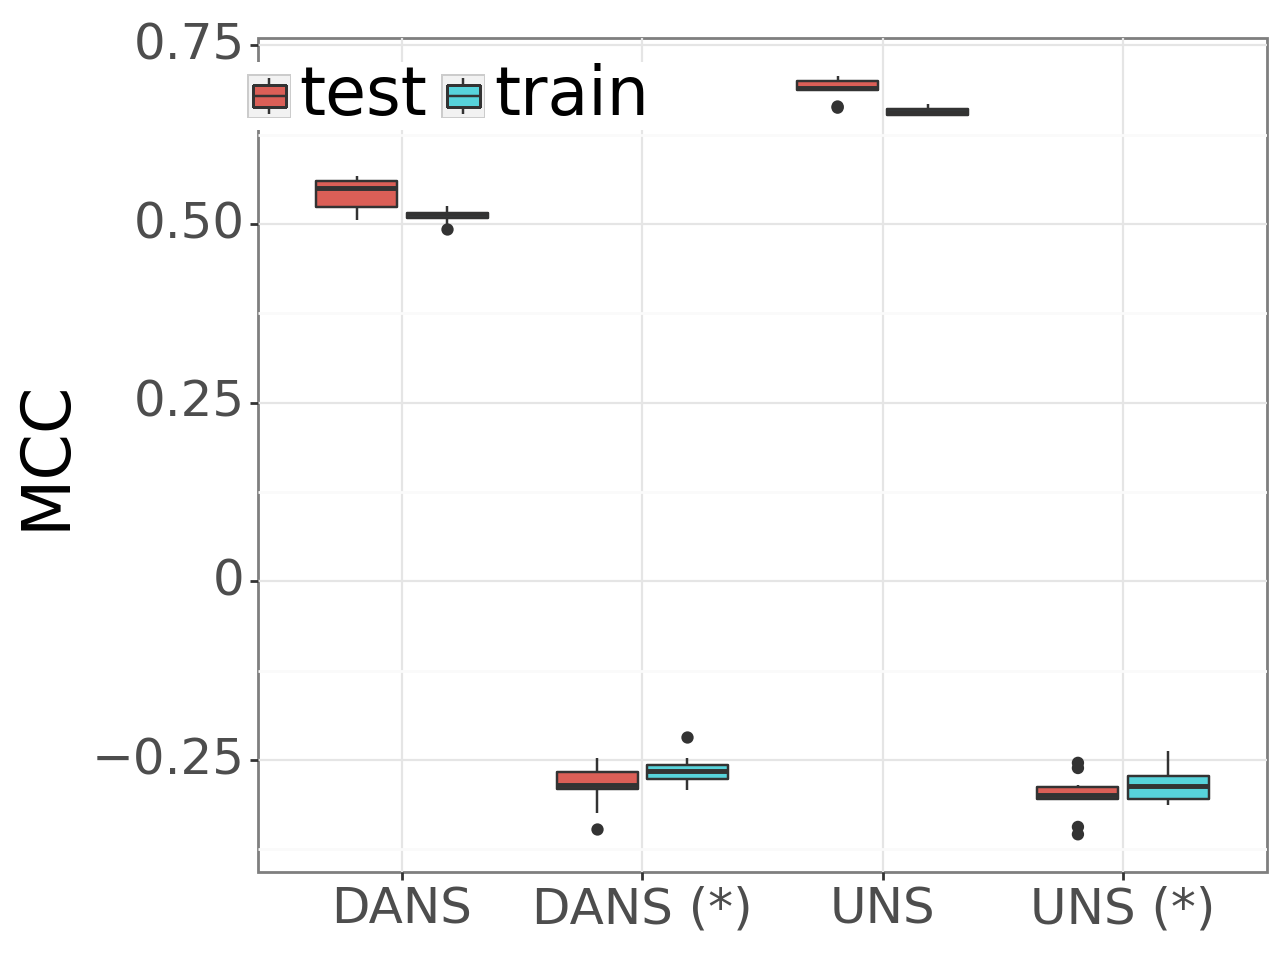

<Figure Size: (640 x 480)>

In [166]:
p = get_ggplot(perceptron_df, "['ResourceAllocationIndex']")
p

<h3>Feature Type: PreferentialAttachment</h3>

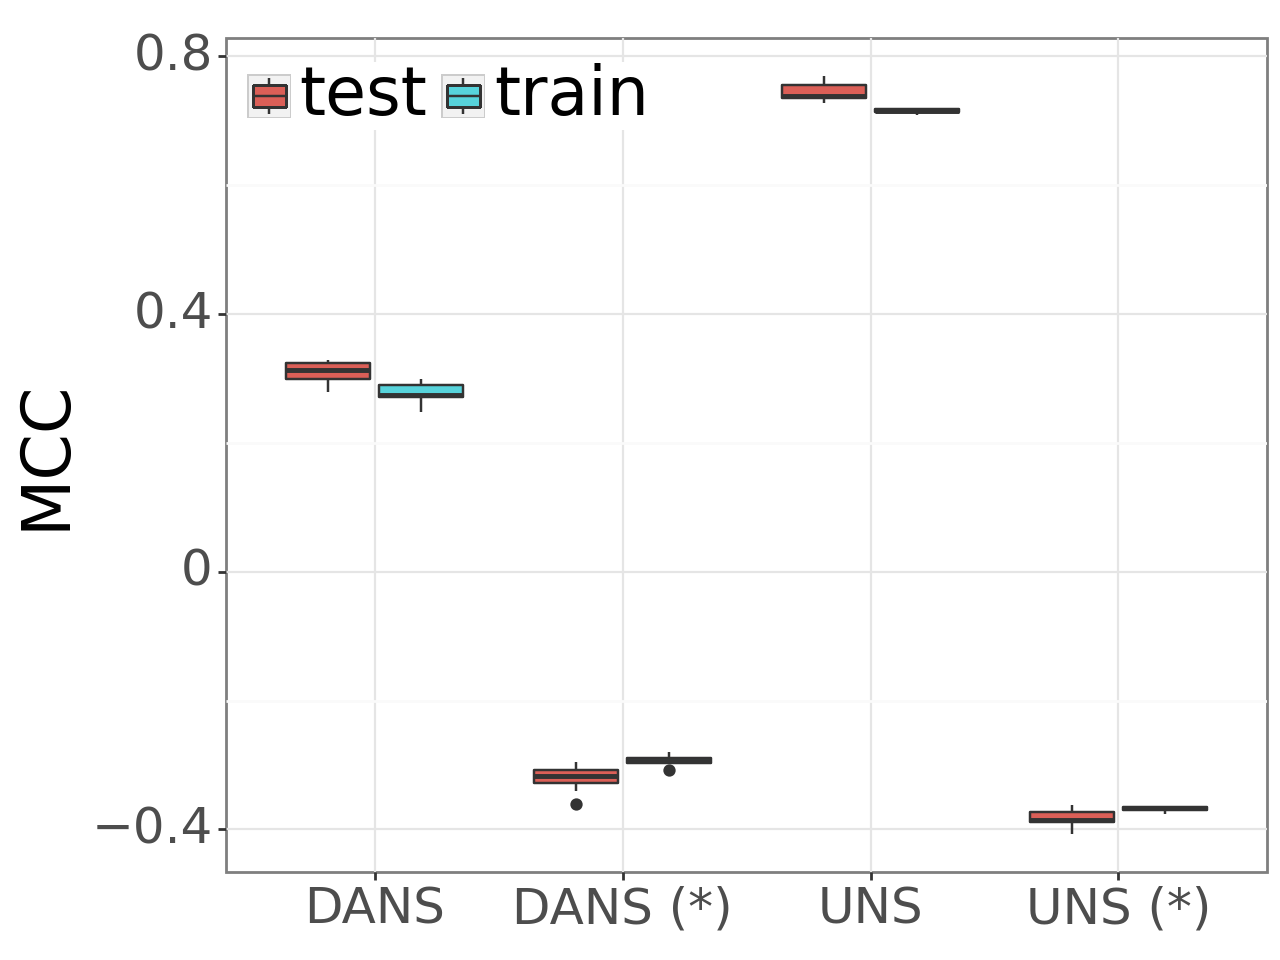

<Figure Size: (640 x 480)>

In [167]:
p = get_ggplot(perceptron_df,"['PreferentialAttachment']")
p